# MNIST Project

In this blog, we will attempt to predict MNIST digits with very simple approach. Instead of using neural networks, we will find a mean of target images and compare an image with that. If the image is similar to one of our means, that's our prediction. 

This is part of Further Research from fastbook [chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb).

We import libraries. Even though we're not going to be using fastai's neural network, it's just easy to import everything rather than trying to figure out individual libraries and functions I need.

In [ ]:
from fastai.vision.all import *

In [ ]:
matplotlib.rc('image', cmap='Greys')

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [ ]:
(path/'training').ls()

(#10) [Path('training/7'),Path('training/8'),Path('training/5'),Path('training/6'),Path('training/9'),Path('training/3'),Path('training/2'),Path('training/0'),Path('training/4'),Path('training/1')]

I looked at the number of files for each number, and they are not the same.

In [ ]:
{n: len((path/'training'/str(n)).ls()) for n in range(10)}

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

Since these are paths for images we have to convert them into pytorch tensors. We can use python list to calculate means and our predictions, but pytorch provides us with [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) ability. This speeds up a lot. We could've used numpy as well here since we're not using GPU or calculating gradients.

First, we turn image paths into numbers and return as L, which is an upgraded version of list. 

In [ ]:
def create_images(path):
    return L(PILImage.create(x) for x in path.ls())

In [ ]:
ones = create_images(path/'training'/'1')
im1 = ones[0]
im1

We need to turn them into tensors for speed. However, we have to check the shape of tensors to make sure they are broadcastable and the shape is one we're expecting.

In [ ]:
def create_tensor_imgs(imgs):
    "Convert a list of images into a tensor"
    return torch.stack([tensor(im) for im in imgs])

In [ ]:
stacked_ones = create_tensor_imgs(ones)
stacked_ones[0].shape

torch.Size([28, 28, 3])

In [ ]:
stacked_ones.shape

torch.Size([6742, 28, 28, 3])

Looking at the shape of an image, it is interesting to find out that its shape is [28, 28, 3] (y, x, and color values). I was expecting to see [28, 28] (y and x values) because it is a black and white image. So, let's see what's going on here.

In [ ]:
array(im1)[10:15, 12:15]

array([[[  0,   0,   0],
        [221, 221, 221],
        [251, 251, 251]],

       [[ 64,  64,  64],
        [236, 236, 236],
        [251, 251, 251]],

       [[127, 127, 127],
        [251, 251, 251],
        [251, 251, 251]],

       [[127, 127, 127],
        [251, 251, 251],
        [251, 251, 251]],

       [[128, 128, 128],
        [253, 253, 253],
        [253, 253, 253]]], dtype=uint8)

So, it is just filled with the same numbers per each row. We just need one column, so we can simply take a mean of last rank.

In [ ]:
array(im1)[10:15, 12:15].mean(-1)

array([[  0., 221., 251.],
       [ 64., 236., 251.],
       [127., 251., 251.],
       [127., 251., 251.],
       [128., 253., 253.]])

So, here is the updated version of `create_tensor_imgs` that calculates a mean so that we can get rid of the last rank of our tensors. 

In [ ]:
def create_tensor_imgs(imgs):
    "Convert a list of images into a tensor"
    return torch.stack([tensor(im) for im in imgs]).mean(-1, dtype=torch.float)

In [ ]:
stacked_ones = create_tensor_imgs(ones)
stacked_ones[0].shape

torch.Size([28, 28])

In [ ]:
array(stacked_ones[0])[10:15, 12:15]

array([[  0., 221., 251.],
       [ 64., 236., 251.],
       [127., 251., 251.],
       [127., 251., 251.],
       [128., 253., 253.]], dtype=float32)

Looks good. Now, we want those pixel values to be between 0 and 1 so that it is easier to train neural networks. However, we do not need to do it here as we're simply finding a mean. It still gives the same result in the end, so we'll divide them by 255. 

In [ ]:
def create_tensor_imgs(imgs):
    "Convert a list of images into a tensor"
    return torch.stack([tensor(im) for im in imgs]).mean(-1, dtype=torch.float)/255

In [ ]:
stacked_ones = create_tensor_imgs(ones)
array(stacked_ones[0])[10:15, 12:15]

array([[0.        , 0.8666667 , 0.9843137 ],
       [0.2509804 , 0.9254902 , 0.9843137 ],
       [0.49803922, 0.9843137 , 0.9843137 ],
       [0.49803922, 0.9843137 , 0.9843137 ],
       [0.5019608 , 0.99215686, 0.99215686]], dtype=float32)

Let's take a look at its mean.

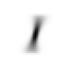

In [ ]:
mean1 = stacked_ones.mean(0)
show_image(mean1);

Well, that looks like 1. Now, we can use this to predict whether an image is 1 or not. This will give us a good baseline. If our deep learning model performs worse than this baseline, we know the model is not performing well. 

Now we have a mean for all images of 1, we can do the same for other numbers as well. It would be easier to define a function that does all the steps.

In [ ]:
def stacked_nums(path):
    "Converts path into stacked tensors."
    imgs = create_images(path)
    return create_tensor_imgs(imgs)

In [ ]:
stacked_zeros = stacked_nums(path/'training'/'0')
stacked_twos = stacked_nums(path/'training'/'2')
stacked_threes = stacked_nums(path/'training'/'3')
stacked_fours = stacked_nums(path/'training'/'4')
stacked_fives = stacked_nums(path/'training'/'5')
stacked_sixs = stacked_nums(path/'training'/'6')
stacked_sevens = stacked_nums(path/'training'/'7')
stacked_eights = stacked_nums(path/'training'/'8')
stacked_nines = stacked_nums(path/'training'/'9')

mean0 = stacked_zeros.mean(0)
mean2 = stacked_twos.mean(0)
mean3 = stacked_threes.mean(0)
mean4 = stacked_fours.mean(0)
mean5 = stacked_fives.mean(0)
mean6 = stacked_sixs.mean(0)
mean7 = stacked_sevens.mean(0)
mean8 = stacked_eights.mean(0)
mean9 = stacked_nines.mean(0)

In [ ]:
all_means = torch.stack([mean0, mean1, mean2, mean3, mean4, mean5, mean6, mean7, mean8, mean9])

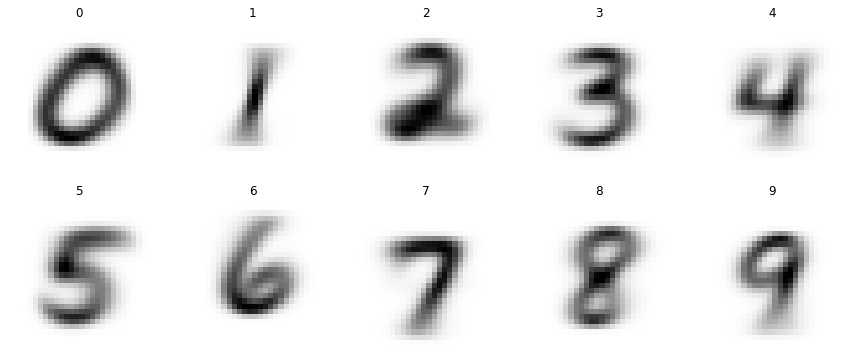

In [ ]:
show_images(all_means, 
            nrows=2,
            titles=[0,1,2,3,4,5,6,7,8,9])

There we go, we got all the means for each number. Let's do the same for testing data.

In [ ]:
tst_0_tens = stacked_nums(path/'testing'/'0')
tst_1_tens = stacked_nums(path/'testing'/'1')
tst_2_tens = stacked_nums(path/'testing'/'2')
tst_3_tens = stacked_nums(path/'testing'/'3')
tst_4_tens = stacked_nums(path/'testing'/'4')
tst_5_tens = stacked_nums(path/'testing'/'5')
tst_6_tens = stacked_nums(path/'testing'/'6')
tst_7_tens = stacked_nums(path/'testing'/'7')
tst_8_tens = stacked_nums(path/'testing'/'8')
tst_9_tens = stacked_nums(path/'testing'/'9')

tst_tens = L([tst_0_tens, tst_1_tens, tst_2_tens, tst_3_tens, tst_4_tens, 
              tst_5_tens, tst_6_tens, tst_7_tens, tst_8_tens, tst_9_tens])
tst_1_tens.shape, tst_9_tens.shape

(torch.Size([1135, 28, 28]), torch.Size([1009, 28, 28]))

So, now that our data is ready, let's figure out how to make a prediction. One way to make a prediction is to calculate the difference between a given image and our means. For each mean, we will calculate the difference, which is a loss. Whatever has the minimum loss is our prediction. Let's use 4 as an example here.

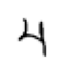

In [ ]:
four = tst_4_tens[0]
show_image(four);

We're calculating mean absolute error (MAE) to find the loss. We need to use absolute values because we do not want negative difference to cancel out with positive one.

In [ ]:
(four - mean0).abs().mean((-1,-2))

tensor(0.1861)

In [ ]:
def mnist_distance(x):
    "Calculate Mean Absolute Error for each mean."
    return (x - all_means).abs().mean((-1, -2))

In [ ]:
preds = mnist_distance(four)
preds

tensor([0.1861, 0.1281, 0.1543, 0.1474, 0.1051, 0.1423, 0.1446, 0.1271, 0.1571,
        0.1132])

From these numbers, we are looking for an index of the smallest one. The smallest distance means a given image is the closest to that mean.

In [ ]:
def mk_pred(x):
    "Make a prediction from a given image."
    dist = mnist_distance(x)
    return dist.argmin(0)

In [ ]:
mk_pred(four)

tensor(4)

That's good. Let's try it on all the images and find out the accuracy of all of them. One problem is that we cannot simply use braodcasting because of their shapes. Let's take a look at their shapes.

In [ ]:
tst_4_tens.shape, all_means.shape

(torch.Size([982, 28, 28]), torch.Size([10, 28, 28]))

First rank of `tst_4_tens` and `all_means` are different and neither is 1. That's a problem, so we can add a dimension over there. We can either use slice or `view`.

In [ ]:
mnist_distance(tst_4_tens[0])

tensor([0.1861, 0.1281, 0.1543, 0.1474, 0.1051, 0.1423, 0.1446, 0.1271, 0.1571,
        0.1132])

In [ ]:
mnist_distance(tst_4_tens[:,None,::])[0]

tensor([0.1861, 0.1281, 0.1543, 0.1474, 0.1051, 0.1423, 0.1446, 0.1271, 0.1571,
        0.1132])

In [ ]:
mnist_distance(tst_4_tens.view(-1, 1, 28, 28))[0]

tensor([0.1861, 0.1281, 0.1543, 0.1474, 0.1051, 0.1423, 0.1446, 0.1271, 0.1571,
        0.1132])

Now we have a way of finding `mnist_distance` efficiently, we have to tweak `mk_pred` a bit to account for it.

In [ ]:
def mk_pred(ts):
    "Make predictions from tensors."
    ranks = len(ts.shape)
    if ranks == 2:
        dist = mnist_distance(ts)
        return dist.argmin(0)
    elif ranks == 3:
        dist = mnist_distance(ts.view(-1, 1, 28, 28))
        return dist.argmin(1)
    else:
        raise Exception(f'Invalid ranks of the tensor. Got {ranks} when 2 or 3 are needed.')

In [ ]:
(mk_pred(tst_4_tens) == 4)[:5]

tensor([True, True, True, True, True])

In [ ]:
[mk_pred(x)==4 for x in tst_4_tens[:5]]

[tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]

With this new function, we can find the accuracy of the test set of numbers.

In [ ]:
(mk_pred(tst_4_tens) == 4).float().mean()

tensor(0.6680)

In [ ]:
(mk_pred(tst_0_tens) == 0).float().mean()

tensor(0.8153)

In [ ]:
def get_acc(ts, targ):
    "Find an accuracy."
    return (mk_pred(ts) == targ).float().mean() * 100

In [ ]:
get_acc(tst_0_tens, 0)

tensor(81.5306)

So, here is the accuracy of all the numbers.

In [ ]:
L(get_acc(ts, targ) for ts, targ in zip(tst_tens, range(10)))

(#10) [tensor(81.5306),tensor(99.8238),tensor(42.3450),tensor(60.8911),tensor(66.8024),tensor(32.6233),tensor(78.7056),tensor(76.4591),tensor(44.2505),tensor(77.6016)]

In [ ]:
acc_dict = {targ:array(get_acc(ts, targ)) for ts, targ in zip(tst_tens, range(10))}
acc_dict

{0: array(81.53061, dtype=float32),
 1: array(99.82379, dtype=float32),
 2: array(42.34496, dtype=float32),
 3: array(60.89109, dtype=float32),
 4: array(66.802444, dtype=float32),
 5: array(32.623318, dtype=float32),
 6: array(78.705635, dtype=float32),
 7: array(76.459145, dtype=float32),
 8: array(44.25051, dtype=float32),
 9: array(77.601585, dtype=float32)}

We can create a graph and look at it visually.

In [ ]:
df = pd.DataFrame(acc_dict, index=range(1))
df

,0,1,2,3,4,5,6,7,8,9
0,81.530609,99.823792,42.344959,60.89109,66.802444,32.623318,78.705635,76.459145,44.250511,77.601585


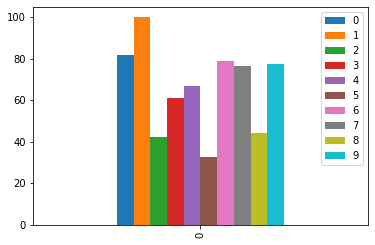

In [ ]:
df.plot.bar();

So, our model is very good at predicting 1, but not as good at predicting 5.

In [ ]:
sum(acc_dict.values())/10

66.1033088684082

Overall, we have 66% accuracy. That's not bad for a starting point. Now, our next step is to build a better model using neural networks.